<a href="https://colab.research.google.com/github/notsurez/GolfCaddie/blob/main/Senior_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu
!pip install pyyaml h5py  # Required to save models in HDF5 format

     |████████████████████████████████| 497.5 MB 21 kB/s 
     |████████████████████████████████| 462 kB 42.6 MB/s 


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# New Section

In [ ]:

from google.colab import files
uploaded = files.upload()

Saving Beginner.csv to Beginner.csv


In [ ]:

from google.colab import files
 
 
uploaded = files.upload()

Saving Intermediate.csv to Intermediate.csv


In [ ]:

from google.colab import files
 
 
uploaded = files.upload()

Saving Advanced.csv to Advanced.csv


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import concatenate, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
import math
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

## **Load our data into the colab notebook**

In [ ]:
import numpy as np

with open("Beginner.csv") as file_name:
    train_data1 = np.loadtxt(file_name, delimiter=",")

test_data1 = train_data1;
train_labels1 = train_data1;
test_labels1 = train_data1;
train_data1= np.delete(train_data1,slice(0,19500,1),axis = 0)
train_data1 = np.delete(train_data1,slice(3,4,1),axis = 1)
train_labels1 = np.delete(train_labels1,slice(0,3,1), axis = 1)
train_labels1= np.delete(train_labels1,slice(0,19500,1),axis = 0)
test_data1 = np.delete(test_data1,slice(19500,97500,1), axis = 0)
test_data1 = np.delete(test_data1,slice(3,4,1),axis = 1)
test_labels1 = np.delete(test_labels1,slice(0,3,1), axis = 1)
test_labels1 = np.delete(test_labels1,slice(19500,97500,1), axis = 0)


(19500, 1)

In [ ]:
x_train1 = train_data1
y_train1 = train_labels1
x_test1 = test_data1
y_test1 = test_labels1

In [ ]:
import numpy as np

with open("Intermediate.csv") as file_name:
    train_data2 = np.loadtxt(file_name, delimiter=",")

test_data2 = train_data2;
train_labels2 = train_data2;
test_labels2 = train_data2;
train_data2= np.delete(train_data2,slice(0,19500,1),axis = 0)
train_data2 = np.delete(train_data2,slice(3,4,1),axis = 1)
train_labels2 = np.delete(train_labels2,slice(0,3,1), axis = 1)
train_labels2= np.delete(train_labels2,slice(0,19500,1),axis = 0)
test_data2 = np.delete(test_data2,slice(19500,97500,1), axis = 0)
test_data2 = np.delete(test_data2,slice(3,4,1),axis = 1)
test_labels2 = np.delete(test_labels2,slice(0,3,1), axis = 1)
test_labels2 = np.delete(test_labels2,slice(19500,97500,1), axis = 0)

In [ ]:
x_train2 = train_data2
y_train2 = train_labels2
x_test2 = test_data2
y_test2 = test_labels2

In [ ]:
import numpy as np

with open("Advanced.csv") as file_name:
    train_data3 = np.loadtxt(file_name, delimiter=",")

test_data3 = train_data3;
train_labels3 = train_data3;
test_labels3 = train_data3;
train_data3 = np.delete(train_data3,slice(0,19500,1),axis = 0)
train_data3 = np.delete(train_data3,slice(3,4,1),axis = 1)
train_labels3 = np.delete(train_labels3,slice(0,3,1), axis = 1)
train_labels3 = np.delete(train_labels3,slice(0,19500,1),axis = 0)
test_data3 = np.delete(test_data3,slice(19500,97500,1), axis = 0)
test_data3 = np.delete(test_data3,slice(3,4,1),axis = 1)
test_labels3 = np.delete(test_labels3,slice(0,3,1), axis = 1)
test_labels3 = np.delete(test_labels3,slice(19500,97500,1), axis = 0)

In [ ]:
x_train3 = train_data3
y_train3 = train_labels3
x_test3 = test_data3
y_test3 = test_labels3

## **Normalize our data**

array([[ 1.27036787],
       [ 0.14073935],
       [ 0.32297222],
       ...,
       [ 0.28171201],
       [-0.56689039],
       [-0.11971217]])

## **Build Our Model**

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation ="relu"),
        layers.Dense(13, activation ="softmax")
    ])
    model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return model

## ***Training the final model***

In [ ]:
model1 = build_model()
history1 = model1.fit(x_train1,
          y_train1,
          epochs=8,
          batch_size=16)
results = model1.evaluate(x_test1, y_test1)


Epoch 1/8
4875/4875 [==============================] - 10s 2ms/step - loss: 1.5354 - accuracy: 0.4228
Epoch 2/8
4875/4875 [==============================] - 8s 2ms/step - loss: 0.9001 - accuracy: 0.6430
Epoch 3/8
4875/4875 [==============================] - 8s 2ms/step - loss: 0.6753 - accuracy: 0.7286
Epoch 4/8
4875/4875 [==============================] - 8s 2ms/step - loss: 0.5382 - accuracy: 0.7831
Epoch 5/8
4875/4875 [==============================] - 8s 2ms/step - loss: 0.4293 - accuracy: 0.8243
Epoch 6/8
4875/4875 [==============================] - 8s 2ms/step - loss: 0.3419 - accuracy: 0.8596
Epoch 7/8
4875/4875 [==============================] - 8s 2ms/step - loss: 0.2902 - accuracy: 0.8790
Epoch 8/8
610/610 [==============================] - 1s 1ms/step - loss: 0.3597 - accuracy: 0.8459


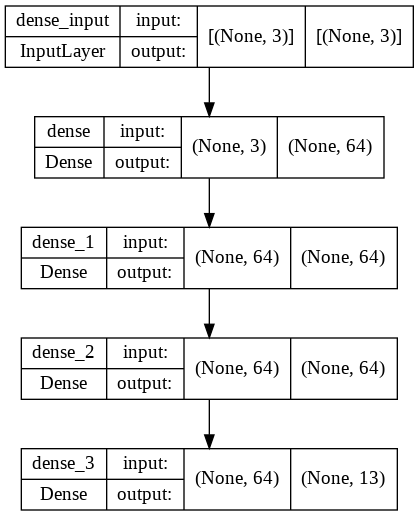

In [ ]:
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

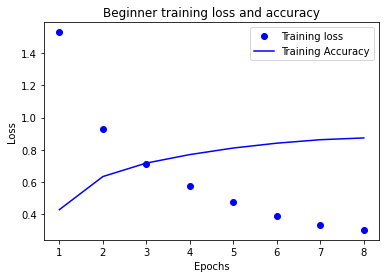

In [ ]:
loss1 = history1.history["loss"]
accuracy1 = history1.history["accuracy"]
epochs = range(1, len(loss1) + 1)
plt.plot(epochs, loss1, "bo", label="Training loss")
plt.plot(epochs, accuracy1, "b", label="Training Accuracy")
plt.title("Beginner training loss and accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 1/8
4875/4875 [==============================] - 9s 2ms/step - loss: 1.5800 - accuracy: 0.4048
Epoch 2/8
4875/4875 [==============================] - 9s 2ms/step - loss: 0.9632 - accuracy: 0.6090
Epoch 3/8
4875/4875 [==============================] - 9s 2ms/step - loss: 0.7445 - accuracy: 0.6922
Epoch 4/8
4875/4875 [==============================] - 9s 2ms/step - loss: 0.6098 - accuracy: 0.7461
Epoch 5/8
4875/4875 [==============================] - 9s 2ms/step - loss: 0.5135 - accuracy: 0.7839
Epoch 6/8
4875/4875 [==============================] - 9s 2ms/step - loss: 0.4405 - accuracy: 0.8129
Epoch 7/8
4875/4875 [==============================] - 9s 2ms/step - loss: 0.3771 - accuracy: 0.8401
Epoch 8/8
610/610 [==============================] - 1s 1ms/step - loss: 0.2168 - accuracy: 0.9208


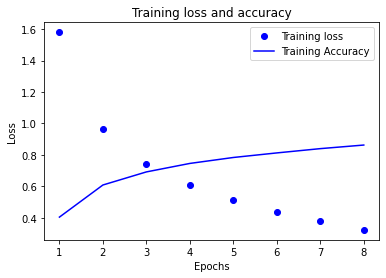

In [ ]:
model2 = build_model()
history2 = model2.fit(x_train2,
          y_train2,
          epochs=8,
          batch_size=16)
results = model2.evaluate(x_test2, y_test2)
loss2 = history2.history["loss"]
accuracy2 = history2.history["accuracy"]
epochs = range(1, len(loss2) + 1)
plt.plot(epochs, loss2, "bo", label="Training loss")
plt.plot(epochs, accuracy2, "b", label="Training Accuracy")
plt.title("Intermediate training loss and accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Epoch 1/8
4875/4875 [==============================] - 9s 2ms/step - loss: 1.6944 - accuracy: 0.3763
Epoch 2/8
4875/4875 [==============================] - 9s 2ms/step - loss: 1.0402 - accuracy: 0.5793
Epoch 3/8
4875/4875 [==============================] - 9s 2ms/step - loss: 0.7885 - accuracy: 0.6736
Epoch 4/8
4875/4875 [==============================] - 9s 2ms/step - loss: 0.6251 - accuracy: 0.7395
Epoch 5/8
4875/4875 [==============================] - 9s 2ms/step - loss: 0.5076 - accuracy: 0.7901
Epoch 6/8
4875/4875 [==============================] - 9s 2ms/step - loss: 0.4056 - accuracy: 0.8322
Epoch 7/8
4875/4875 [==============================] - 9s 2ms/step - loss: 0.3390 - accuracy: 0.8602
Epoch 8/8
610/610 [==============================] - 1s 2ms/step - loss: 0.2546 - accuracy: 0.9005


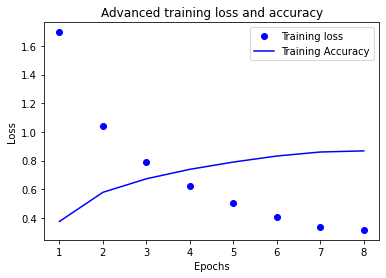

In [ ]:
model3 = build_model()
history3 = model3.fit(x_train3,
          y_train3,
          epochs=8,
          batch_size=16)
results = model3.evaluate(x_test3, y_test3)
loss3 = history3.history["loss"]
accuracy3 = history3.history["accuracy"]
epochs = range(1, len(loss3) + 1)
plt.plot(epochs, loss3, "bo", label="Training loss")
plt.plot(epochs, accuracy3, "b", label="Training Accuracy")
plt.title("Advanced training loss and accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
model1.save('Senior_Project_Beginner.h5') 
model2.save('Senior_Project_Intermediate.h5')
model3.save('Senior_Project_Advanced.h5')